# Troubleshooting the Tweet Generator - debug issue that's now been solved, for reference only

One of the limitations of the generator revealed by inspecting various generations, is that if the buffer (64 characters) is not full, the model seems to generate gibberish. Let's take a closer look at what's going on.

In [111]:
import numpy as np
import pandas as pd
import data_load_utils as util
from math import ceil

In [112]:
tweets = util.filter_tweets_min_count(util.read_tweet_data('data/emojis_homemade.csv'), min_count=1000)
tweets['text'] = util.filter_text_for_handles(tweets['text'])

MAX_TWEET_LENGTH = 160
WINDOW_SIZE = 64
STEP = 3

samples_per_tweet = int(ceil((MAX_TWEET_LENGTH - WINDOW_SIZE) / STEP)) # 32
tweets_per_batch = 64
samples_per_batch = samples_per_tweet * tweets_per_batch # 2048

chars_univ, chars_univ_idx = util.get_universal_chars_list()

In [113]:
# Once again, lets load up the train/dev sets we trained the model on.

TRAIN_SIZE = 2**18 # 262,144 training examples
DEV_SIZE = 2**12   # 4096 Dev examples

n_train_batches = TRAIN_SIZE / tweets_per_batch
n_dev_batches = DEV_SIZE / tweets_per_batch

tweets_train = tweets.iloc[0:TRAIN_SIZE] 
tweets_dev = tweets.iloc[TRAIN_SIZE:TRAIN_SIZE+DEV_SIZE] 

# Distribution of the training data
How many training examples were composed of what proportion of a) whitespace b) URLs?

In [114]:
# pad the tweets as we would do for turning them into series
tweets['text'] = tweets['text'].apply(util.pad_text)

tweets['whitespace']=tweets['text'].apply(lambda x: x.count(" "))



In [115]:
tweets.head()




                                                text emoji  whitespace
0                                              RT...     ©          63
1                                                ...     💫          68
2                                        RT Now y...     😎          54
3                                                ...     💛         148
6                                                ...     😩         143

In [116]:
tweets.iloc[1]['text']

'                                                    RT 181023 Kris Wu Studio update (3/3)Legendary creator at The Next Top Bang press conference #KrisWu #Wuyifa'

Check on how short tweets (< 64 characters) are represented to the model. Is the text at the start (trailing whitespace) or the end (preceding whitespace) of the model?

In [117]:
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

(array([9.0000e+00, 2.8370e+03, 3.6995e+04, 6.3956e+04, 4.6464e+04,
        5.9987e+04, 6.7291e+04, 7.5792e+04, 5.1695e+04, 5.6518e+04]),
 array([ 16. ,  30.4,  44.8,  59.2,  73.6,  88. , 102.4, 116.8, 131.2,
        145.6, 160. ]),
 <a list of 10 Patch objects>)

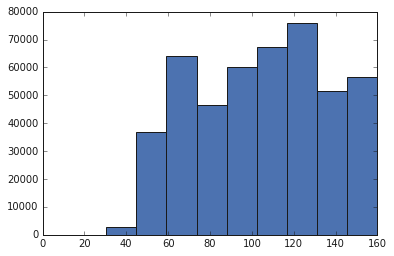

In [118]:
%matplotlib inline
plt.hist (tweets['whitespace'])

(array([5.6518e+04, 5.1695e+04, 7.5792e+04, 6.7291e+04, 5.6231e+04,
        5.0220e+04, 6.3956e+04, 3.6995e+04, 2.8370e+03, 9.0000e+00]),
 array([  0. ,  14.4,  28.8,  43.2,  57.6,  72. ,  86.4, 100.8, 115.2,
        129.6, 144. ]),
 <a list of 10 Patch objects>)

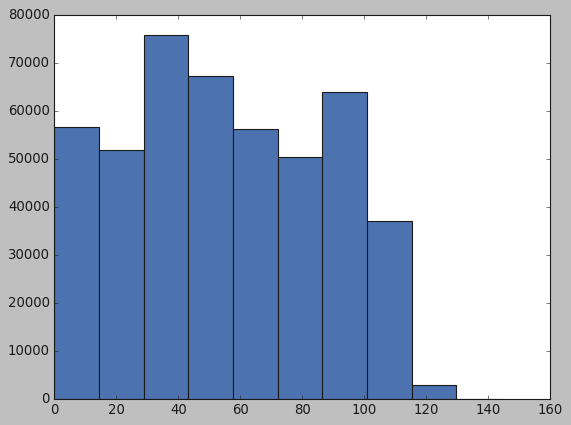

In [119]:
tweets['characters'] = 160 - tweets['whitespace']
%matplotlib inline
plt.style.use('classic')
plt.hist (tweets['characters'])
# ax = plt.axes()
# ax.set_axisbelow(True)


In [120]:
import keras
from keras import layers
from keras.models import Sequential
from keras import callbacks

In [121]:
model = keras.models.load_model("models/tweet_gen_model-train250k-0.830.hdf5") # 256 LSTM units, ~30 epochs training 

# Manually troubleshoot what happens when seed text is largely whitespace

What are the edge cases?

In [122]:
def sample (preds, temperature = 1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [123]:
import tensorflow as tf
import random
import sys

In [124]:
def generate_tweet(seed_text, length=MAX_TWEET_LENGTH, temperatures=[0.3, 0.5, 0.8, 1.0], random_seed = None):

    if random_seed:
        np.random.seed(random_seed) # np.random.seed needed by tf 
        tf.set_random_seed(random_seed)
    else:
        print ("no!")
    
    n_seed_chars = len(seed_text) 
    print ('--- Generating with seed:' + seed_text +  '[' + str(len(seed_text)) + ']')

    # try a range of sampling temperatures
    for temperature in temperatures:
        generated_text = seed_text
        print ('--------- temperature:', temperature)
        sys.stdout.write(generated_text)

        for i in range (length - n_seed_chars):
            # one-hot encode the characters generated so far
            sampled = np.zeros((1, WINDOW_SIZE, len(chars_univ)))
            for t, char in enumerate (generated_text):
                sampled[0, t, chars_univ_idx[char]] = 1

            # sample the next character
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars_univ[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)

        print ("\n")    

In [125]:
def get_seed_text(tweets, random_seed = None):
    if random_seed:
        np.random.seed(random_seed)
        
    seed_tweet = tweets.iloc[np.random.randint(0, len(tweets))]
    seed_text = seed_tweet['text'][0:seed_length]

    print (seed_text + "\n" + seed_tweet['text'])
    
    return seed_text

When the text is at least 64 characters, the model generates actual words

In [126]:
seed_text = "A dataset-oriented API for examining relationships between multiple"
seed_text = seed_text[0:64]

generate_tweet(seed_text, temperatures=[0.4, 0.8], random_seed = 1)

--- Generating with seed:A dataset-oriented API for examining relationships between multi[64]
--------- temperature: 0.4
A dataset-oriented API for examining relationships between multi

ng and st

arted the wo

rld and st

art the setti

ng on 

the house be

fore the w

ay to the c

hance.  of th

--------- temperature: 0.8
A dataset-oriented API for examining relationships between multife

s, check I

 have mor

e first ch

ings      # # 

#assul #

 #in #ra

perandeh #dise

a #spotted 

#beauts #f



But when the text is shorter than 64 characters, gibberish ensues

In [127]:
seed_text_short = "A dataset-oriented API for examining relationships between mult"
seed_text_short = seed_text_short[0:64]
print (len(seed_text_short))

generate_tweet(seed_text_short, temperatures=[0.4, 0.8], random_seed = 1)

63
--- Generating with seed:A dataset-oriented API for examining relationships between mult[63]
--------- temperature: 0.4
A dataset-oriented API for examining relationships between mult

l i    

     i

la

wYhtg 

i ms

gialsacsa 

ak 

aaoo

 l

      

--------- temperature: 0.8
A dataset-oriented API for examining relationships between multl is

s

asa lv   

 )

is1 /AP AI

TU

 Ls 8 sukahh

p

cdag isur ps

r

kimn ?Vji 

adl i mN fe

ltwe ino ls h  

4htuhu 



Does padding the seed text with whitespace make a difference? 

In [128]:
seed_text_pad_back = "A dataset-oriented API for examining relationships between mul  "
seed_text_pad_back = seed_text_pad_back[0:64]
print (len(seed_text_pad_back))

generate_tweet(seed_text_pad_back, temperatures=[0.4, 0.8], random_seed = 1)

64
--- Generating with seed:A dataset-oriented API for examining relationships between mul  [64]
--------- temperature: 0.4
A dataset-oriented API for examining relationships between mul  h

ttps:/

/t

.co/

mlHdDuMr

zr

  #

 # # 

# 

#  

   :

 da

t

h      

  

--------- temperature: 0.8
A dataset-oriented API for examining relationships between mul  is

 b

ecause

 the

3ym, 

that

 p

ain !

wh

y mag

u i

n 

bunny

 th

r

y and

 I 

l

ove it I 

mea

n you 

t

rynning

 som

e 



In [129]:
seed_text_pad_front = "  A dataset-oriented API for examining relationships between mul"
seed_text_pad_front = seed_text_pad_front[0:64]
print (len(seed_text_pad_front))

generate_tweet(seed_text, temperatures=[0.4, 0.8], random_seed = 1)

64
--- Generating with seed:A dataset-oriented API for examining relationships between multi[64]
--------- temperature: 0.4
A dataset-oriented API for examining relationships between multing a

nd

starte

d t

h

e wor

ld 

a

nd start

 the 

s

ettin

g o

n

 the

 ho

u

se b

efo

r

e th

e 

w

ay t

o t

he c

hance

. 

 of

 th

--------- temperature: 0.8
A dataset-oriented API for examining relationships between multifes

, 

che

ck I h

av

e m

ore fi

r

st

 chi

n

gs  

    # # 

#assul

 # #in

 #r

apera

ndeh

 #disea

 #

spotte

d #b

eauts 

#f



So pad the seed text and it works fine. What is going on with feeding the seed text to the model when it's not padded that causes the gibberish?  Let's look at what the code for the generate_tweet function does:

In [130]:
generated_text = seed_text_short
print (len(generated_text))

# one-hot encode the characters generated so far
sampled = np.zeros((1, WINDOW_SIZE, len(chars_univ)))
for t, char in enumerate (generated_text):
    sampled[0, t, chars_univ_idx[char]] = 1

sampled.shape

63


(1, 64, 93)

So we still get a 64 x 93 matrix. Lets see how many of the 93 input units (one for each character in the character set) are on for each character in the seed text (should be exactly one)

In [131]:
np.sum(sampled[:,:,:], axis=2)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

Aha - so the problem is when the model receives a `seed_text` thats less than 64 characters, the 93-unit input vector receives nothing, (null) rather than an activation of the unit that should represent the whitespace character.

I'm pretty confident this is a pattern that the model never encountered during training. It's highly likely the model would have learned to deal with this pattern if, in training, whitespace had been represented by null rather than a whitespace character.

For now, let's just make sure the function that generates text always pads it out with whitespace. '

In [133]:
def generate_tweet(seed_text, window_size=WINDOW_SIZE,
		   length=MAX_TWEET_LENGTH, temperatures=[0.3, 0.5, 0.8, 1.0],
		   random_seed = None):

    if random_seed:
        np.random.seed(random_seed) # np.random.seed needed by tf 
        tf.set_random_seed(random_seed)
        
    n_seed_chars = window_size
    #first, pad out the seed_text with whitespace     
    seed_text = util.pad_text(seed_text, window_size)

    print ('--- Generating with seed: "' + seed_text + '" [' + str(len(seed_text)) + ']')

    # try a range of sampling temperatures
    for temperature in temperatures:
        generated_text = seed_text
        print ('--------- temperature:', temperature)
        sys.stdout.write(generated_text)

        for i in range (length - n_seed_chars):
            # one-hot encode the characters generated so far
            sampled = np.zeros((1, WINDOW_SIZE, len(chars_univ)))
            for t, char in enumerate (generated_text):
                sampled[0, t, chars_univ_idx[char]] = 1

            # sample the next character
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars_univ[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)

        print ("\n")    



In [135]:
seed_text = ""
seed_text = seed_text[0:64]
print (len(seed_text))

generate_tweet(seed_text, temperatures=[0.4, 0.6, 0.8, 1.2], random_seed = 1)


64
--- Generating with seed: "@BarnetCouncil We're not giving you any stinking money, and that" [64]
--------- temperature: 0.4
@BarnetCouncil We're not giving you any stinking money, and that they

 sport me 

 

--------- temperature: 0.6
@BarnetCouncil We're not giving you any stinking money, and that bitch and

 not all we s

tarted Alb

um is the he

art and at

tend in th

e mac

hat missage

 in a fe

w marke

--------- temperature: 0.8
@BarnetCouncil We're not giving you any stinking money, and that w

as a peop

le is over su

pport an edat

"s cutelon

  and cutest

 reach an ad

dics 

this mahouss

 all for

--------- temperature: 1.2
@BarnetCouncil We're not giving you any stinking money, and that b

uspen (Couls

 it!!!  Sen

d you  #iKA

MORO5 Mac

kyRelma De

vid hait  

skinne FHY

) and 

havingrat Rud

 y

